In [1]:
from collections import defaultdict
import pickle
from typing import Any, Literal
import numpy as np
from scipy.spatial import KDTree, Voronoi, ConvexHull, voronoi_plot_2d
import scipy.stats
import scipy.special
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from typing import Any, cast, Callable, Tuple, List, List as List_, Union
import warnings
import abc
import numpy as np
import scipy.stats
import scipy.special
import matplotlib.pyplot as plt
import abc


cast_rv_continuous = lambda x: cast(scipy.stats.rv_continuous, x)

IntOrArray = Union[int, np.ndarray]
FloatOrArray = Union[float, np.ndarray]
IntOrList = Union[List_[int], int]
NumArray = Union[List_, np.ndarray, pd.Series, pd.DataFrame]
PForPNorm = Union[Literal[1, 2], float]


class RadialSpace:
    "Hyperspheres in R^d"

    @classmethod
    def d_volume(cls, d: IntOrArray, r: FloatOrArray = 1):
        "Volume enclosed by the hypersphere in d dimensions with radius r"
        return np.pi ** (d / 2) / scipy.special.gamma(1 + d / 2) * r**d

    @classmethod
    def d_surface(cls, d: IntOrArray, r: FloatOrArray = 1):
        "Surface of the hypersphere in d dimensions with radius r, i.e. derivative of volume(r) wrt r"
        return np.pi ** (d / 2) / scipy.special.gamma(1 + d / 2) * r ** (d - 1) * d

    _cache_instances = {}  # class attribute to cache instances

    def __new__(cls, d: int):
        key = (cls.__name__, d)
        obj = cls._cache_instances.get(key)
        if obj is not None:
            return obj
        obj = super().__new__(cls)
        obj._init(d)
        cls._cache_instances[key] = obj
        return obj

    def __repr__(self):
        return f"{self.__class__.__name__}({self.d})"

    def _init(
        self, d: int
    ):  # if it was called __init__, it would be called even if cached
        assert d == round(d) and d >= 1, d
        self.d = d
        "Mass of a unit hypersphere in d dimensions with constant unit density"
        self._unit_vol = self.d_volume(1)
        self._unit_surface = self.d_surface(1)

    def volume(self, r: FloatOrArray = 1):
        return self.d_volume(self.d, r)

    def surface(self, r: FloatOrArray = 1):
        return self.d_surface(self.d, r)

    def random_on_surface(self, r: FloatOrArray = 1, size=None):
        "Draw uniformly from the sphere surface"
        r = np.asarray(r).astype(float)
        shape = r.shape if size is None else tuple(np.ravel(size))
        X = np.random.normal(0, 1, size=(*shape, self.d))
        X /= r * np.linalg.norm(X, axis=-1, keepdims=True)
        return X

    def surface_marginal_pdf(self, r: FloatOrArray = 1, d: Union[int, None] = None):
        "Draw uniformly from the sphere surface and take the first coordinate, ignoring the rest"
        r = np.asarray(r).astype(float)
        d = self.d if d is None else d
        rv = cast_rv_continuous(scipy.stats.beta((d - 1) / 2, (d - 1) / 2))
        return rv.pdf((r + 1) / 2) / 2

    def alt_random_surface_marginal(self, r: FloatOrArray = 1, size=None, d=None):
        "Alternative to self.random(r, size)[:,0]"
        r = np.asarray(r).astype(float)
        d = self.d if d is None else d
        if d == 1:  # (special case: Rademacher distribution)
            return (2 * np.random.randint(0, 2, size=size) - 1.0) * r
        rv = cast_rv_continuous(scipy.stats.beta((d - 1) / 2, (d - 1) / 2))
        return (rv.rvs(size=size) * 2 - 1) * r


# -----------------------------


class IstotropicDistribution:
    """
    The total mass is 1 = integral of norm_pdf(r) dr.
    """

    _r_plot: float  # large radius for plotting purposes

    def __init__(self, d: int, r: float = 1.0):
        """
        d: int (dimensionality)
        r: float (radial scale, default 1.0)
        """
        assert d == round(d) and d >= 1, d
        self.space = RadialSpace(d)
        self.d = d
        self.r = r
        self._r_plot = self.r * self.d**0.5 * 2
        self.fuzzy_radius = np.nan  # Must be set by each subclass
        self._post_init()

    @classmethod
    def from_fuzzy_radius(cls, d: int, fuzzy_radius: float):
        "Create a distribution with a given fuzzy_radius"
        r = fuzzy_radius / cls(d, 1).fuzzy_radius
        # # Reminder: Alternative using scipy solver:
        # f = lambda r: cls(d, r).fuzzy_radius - fuzzy_radius
        # r = scipy.optimize.root_scalar(f, bracket=[1e-10, 1e10]).root
        obj = cls(d, r)
        assert np.isclose(obj.fuzzy_radius, fuzzy_radius), (
            obj.fuzzy_radius,
            fuzzy_radius,
        )
        return obj

    def _post_init(self):
        pass

    def __repr__(self):
        return f"{self.__class__.__name__}({self.d}, r={self.r})"

    @abc.abstractmethod
    def norm_pdf(self, r: FloatOrArray):
        "Density of |X| for X~self. (r>=0)"
        raise NotImplementedError

    def norm_cdf(self, r: FloatOrArray):
        "probability mass that is enclosed in the hypersphere of radius r. (r>=0)"
        raise NotImplementedError

    def random(self, size=None):
        "Draw a sample from the distribution"
        X = self.space.random_on_surface(1, size=size)
        X *= self.random_norm(size)[..., None]
        return X

    @abc.abstractmethod
    def random_norm(self, size=None):
        raise NotImplementedError

    def pointwise_irradiance(self, r: FloatOrArray):
        """
        Equals norm_pdf(r) / space.surface(r)
        This is the "euclidean density" in the following sense:
        Fix any point x at radius r, let B(l) be the hypercube of side l centered at x.
        The pointwise_irradiance is the limit as l goes to 0 of the integral of the distribution
        over B(l) divided by the norm_cdf of l.
        """
        r = np.where(r == 0, 1e-20, r)  # Correction for singularity of some rvs
        return self.norm_pdf(r) / self.space.surface(r)

    def fuzzy_membership(self, r: FloatOrArray):
        # Returns a number in [0,1]
        return self.pointwise_irradiance(r) / self.pointwise_irradiance(0)

    def _ref_marginal(self, r: FloatOrArray):
        "Just for plotting purposes"
        raise NotImplementedError

    def _ref_irradiance(self, r: FloatOrArray) -> FloatOrArray:
        "Just for plotting purposes"
        raise NotImplementedError

    def marginal_pdf(self, x: FloatOrArray) -> FloatOrArray:
        "Just for plotting purposes"
        raise NotImplementedError

    def _compute_marginal_pdf(self, x: float) -> float:
        "Explicit computation in case no formula is available"
        warnings.warn(f"May have bugs. Not tested yet!")
        f = lambda r: self.pointwise_irradiance(
            (r**2 + x**2) ** 0.5
        ) * self.space.d_surface(self.d - 1, r)
        return scipy.integrate.quad(f, 0, np.inf)[0]

    def random_marginal(self, r: FloatOrArray = 1, size=None):
        "Alternative to self.random(r, size)[:,0]"
        r = np.asarray(r).astype(float)
        return self.space.alt_random_surface_marginal(size=size) * self.random_norm(
            size=size
        )


class ScipyIsotropicDistribution(IstotropicDistribution):
    _rv: scipy.stats.rv_continuous

    def random_norm(self, size=None):
        return self._rv.rvs(size) * self.r

    def norm_pdf(self, r: FloatOrArray):
        "Density for the prob. that a point chosen uniformly from the hypersphere (norm_cdf) has radius r. (r>=0)"
        return self._rv.pdf(r / self.r) / self.r

    def norm_cdf(self, r: FloatOrArray):
        return self._rv.cdf(r / self.r)

    def norm_rms(self):
        return (self.r**2 * self._rv.moment(2)) ** 0.5

    def norm_mean(self):
        return self._rv.moment(1) * self.r


class UniformIsotropicDistribution(ScipyIsotropicDistribution):
    def _post_init(self):
        super()._post_init()
        self._rv = cast_rv_continuous(scipy.stats.beta(self.d, 1))
        self._rv_marginal = cast_rv_continuous(
            scipy.stats.beta((self.d + 1) / 2, (self.d + 1) / 2)
        )
        self._r_plot = self.r * 1.2
        self.fuzzy_radius = self.r

    def _ref_irradiance(self, r: FloatOrArray):
        return np.where(r < self.r, 1, 0) / self.space.volume(self.r)

    def marginal_pdf(self, x: FloatOrArray):
        # Reminder. This is equivalent:
        # return self.space.surface_marginal_pdf(x, d=self.d+2) / self.r
        x = np.clip(x / self.r, -1, 1)
        return self._rv_marginal.pdf((x + 1) / 2) / self.r / 2

    def random_marginal(self, size=None):
        # Alternative implementation
        return (self._rv_marginal.rvs(size=size) * 2 - 1) * self.r

    # Reminder: Random_radius alternatives:
    # Formula 1: np.random.random(size)**(1/self.d) * self.r
    # Formula 2: np.max(np.random.random((*shape, d)), axis=1) * self.r


class ExponentialIsotropicDistribution(ScipyIsotropicDistribution):

    def _post_init(self):
        super()._post_init()
        self._rv = cast_rv_continuous(scipy.stats.gamma(self.d))
        self._r_plot = self.r * self.d**0.5 * 8
        irr_rv = cast_rv_continuous(scipy.stats.expon())
        self.fuzzy_radius = self.r / irr_rv.pdf(0)

    def _ref_irradiance(self, r: FloatOrArray):
        c = scipy.special.gamma(self.d) * self.space.surface(self.r)
        return 1 / self.r * np.exp(-r / self.r) / c

    def marginal_pdf(self, x: FloatOrArray):
        # if self.d == 1: # Reminder: this code would be equivalent for d=1
        #     return np.exp(-np.abs(x)/self.r) / (2*self.r)
        d = self.d
        G = scipy.special.gamma
        c = 2 ** (d / 2) / np.pi * G(1 + d / 2) / G(1 + d)
        f = lambda x: scipy.special.kv(d / 2, x) * x ** (d / 2)
        return c * f(np.abs(x) / self.r) / self.r


class GaussianIsotropicDistribution(ScipyIsotropicDistribution):

    def _post_init(self):
        super()._post_init()
        self._rv = cast_rv_continuous(scipy.stats.chi(self.d))
        self._r_plot = self.r * self.d**0.5 * 5
        irr_rv = cast_rv_continuous(scipy.stats.halfnorm())
        self.fuzzy_radius = self.r / irr_rv.pdf(0)

    def random(self, size=None):
        shape = () if size is None else tuple(np.ravel(size))
        X = np.random.normal(0, 1, size=(*shape, self.d))
        return X * self.r

    def pointwise_irradiance(self, r: FloatOrArray):
        irr_rv = cast_rv_continuous(scipy.stats.halfnorm())
        c = 2 ** (self.d / 2 + 1) / 5 * scipy.special.gamma(self.d / 2)
        c *= self.space.surface(self.r)
        return irr_rv.pdf(r / self.r) / self.r / c

    def fuzzy_membership(self, r: FloatOrArray):
        irr_rv = cast_rv_continuous(scipy.stats.halfnorm())
        return irr_rv.pdf(r / self.r) / irr_rv.pdf(0)

    def marginal_pdf(self, x: FloatOrArray):
        return scipy.stats.norm.pdf(x / self.r) / self.r


class CategoricalSimplex:
    """
    Embedding for a categorical variable with d categories. There are three types of embeddings:
    - The "categorical space" (cat), where each category is an integer from 0 to d-1
    - The "one-hot space" (oh) or "affine space", where each category is a one-hot vector (in d-dimensions)
    - The "linear space" (lin), where each category is a point in (d-1)-dimensions
    """

    def __init__(
        self,
        n_cat: int,
        lin_scale: Union[float, Literal["unit_side", "match_oh"]] = "match_oh",
        oh_scale: Union[float, Literal["unit_side", "match_lin"]] = 1,
    ):
        """
        lin_scale: float or 'unit_side' or 'match_oh'
            Radius of the simplex in the linear space.
        oh_scale: float or 'unit_side' or 'match_lin'
            Norm of the one-hot-encoded vectors in the one-hot space.
        """
        self.n_cat = n_cat
        self.d = d = n_cat - 1  # Dimensionality of the simplex

        # Default scales. Caution: side and radius scale simultaneously but not vertex_norm because of the affine map
        dt_scales = np.dtype(
            [
                ("vertex_norm", float),
                ("side", float),
                ("radius", float),
                ("factor", float),
            ]
        )
        Scale = lambda values, by: np.array(
            tuple(by * np.array(values.tolist())), dtype=dt_scales
        )
        s_oh = Scale(np.array([1, np.sqrt(2), np.sqrt(d / (d + 1)), 1]), 1.0)
        s_lin = Scale(np.array([1, s_oh["side"] / s_oh["radius"], 1, 1]), 1.0)
        s_lin["factor"] = 1

        # Parse the scale arguments
        f = lambda x, ref: cast(
            Union[float, None],
            1 / ref["side"] if x == "unit_side" else None if isinstance(x, str) else x,
        )
        _s_lin = f(lin_scale, s_lin)
        _s_oh = f(oh_scale, s_oh)
        if _s_lin is None or _s_oh is None:
            if _s_lin is not None:
                s_lin = Scale(s_lin, _s_lin)
                s_oh = Scale(s_oh, s_lin["radius"] / s_oh["radius"])
            elif _s_oh is not None:
                s_oh = Scale(s_oh, _s_oh)
                s_lin = Scale(s_lin, s_oh["radius"] / s_lin["radius"])
            else:
                raise Exception("Cannot have match_oh and match_lin simultaneously")
        else:
            s_lin = Scale(s_lin, _s_lin)
            s_oh = Scale(s_oh, _s_oh)
        self.lin_scale = s_lin
        self.oh_scale = s_oh

        V = self._simplex_vertices(d)  # of radius 1.
        self.isometry = np.sqrt(d / (d + 1)) * V

        self.lin_vertices = self.lin_scale["vertex_norm"] * V
        self.oh_vertices = self.oh_scale["vertex_norm"] * np.eye(d + 1)
        self.oh_centroid = np.mean(self.oh_vertices, axis=0)
        self.lin_volume = (
            np.sqrt((d + 1) / 2**d)
            / scipy.special.gamma(1 + d)
            * self.lin_scale["side"] ** d
        )
        self.oh_volume = (
            np.sqrt((d + 1) / 2**d)
            / scipy.special.gamma(1 + d)
            * self.oh_scale["side"] ** d
        )

    @staticmethod
    def _simplex_vertices(d: int):
        # The columns of V are the vertices of the d-dimensional simplex of radius 1
        assert d > 0
        V = np.array([[-1, 1]])
        k = 2
        while k <= d:
            V_i = [([-1 / k, *(np.sqrt(k**2 - 1) / k * u)]) for u in V.T]
            v_k = [1, *np.zeros(k - 1)]
            V = np.array([v_k, *V_i]).T
            k += 1
        return V

    def _clean_cat(self, X_cat: np.ndarray):
        assert np.all(np.isclose(X_cat, X_cat.astype(int))), X_cat
        X_cat = X_cat.astype(int)
        if len(X_cat.shape) == 2 and X_cat.shape[-1] == 1:
            X_cat = X_cat[:, 0]
        return X_cat

    def cat_to_oh(self, X_cat: np.ndarray):
        return self.oh_vertices.T[self._clean_cat(X_cat)]

    def cat_to_lin(self, X_cat: np.ndarray):
        return self.lin_vertices.T[self._clean_cat(X_cat)]

    def oh_to_cat(self, X: np.ndarray):
        return np.argmax(X, axis=-1)

    def lin_to_cat(self, X: np.ndarray):
        X_OH = self.lin_to_oh(X)
        return self.oh_to_cat(X_OH)

    def oh_to_lin(self, X_oh: np.ndarray):
        # X_oh has rows of one-hot vectors
        X_oh = X_oh / self.oh_scale["side"]
        X_lin = np.matmul(X_oh, self.isometry.T)
        return X_lin * self.lin_scale["side"]

    def lin_to_oh(self, X_lin: np.ndarray):
        X_lin = X_lin / self.lin_scale["side"]
        X_oh = np.matmul(X_lin, self.isometry)
        return X_oh * self.oh_scale["side"] + self.oh_centroid


class NotEnoughNeighbors(Exception):
    pass


class Neighborhood:
    "Collection of possibly weighted points within a radius around a central point in R^d"

    def __init__(
        self, center: np.ndarray, radius: float, points: np.ndarray, weights: np.ndarray
    ):
        self.center = center
        self.radius = radius
        self.points = points
        self.weights = weights


class Ellipsoid:
    "Ellipse in n-dimensions, defined by its center (mu), amplitudes (lambdas) and orthogonal directions (matrix V)"

    def __init__(
        self, mu: np.ndarray, lambdas: np.ndarray, V: Union[None, np.ndarray] = None
    ):
        self.mu = mu
        self.lambdas = lambdas
        self.V = V if V is not None else np.eye(len(mu))
        self.d = len(lambdas)
        assert mu.shape == lambdas.shape, (mu.shape, lambdas.shape)
        assert self.V.shape == (len(mu), len(mu)), self.V.shape
        self.orientation: Union[None, np.ndarray] = None

    def orient(self, neigh: Neighborhood):
        """
        Orient the eigenvectors towards the majority of the data points
        and assign a probability (at least 0.5) of not-inverting for random sampling
        """
        # Project the points onto the ellipsoid to see the direction
        orientation = np.zeros(self.d)
        X = neigh.points - neigh.center
        for i in range(self.d):
            # Count the number of neighbors in the direction of the eigenvector
            dirs = X @ self.V[:, i]
            w_pos = np.sum(neigh.weights[dirs > 0] * dirs[dirs > 0])
            w_neg = np.sum(neigh.weights[dirs < 0] * -dirs[dirs < 0])  # type:ignore
            if np.isclose(w_pos + w_neg, 0):
                orientation[i] = 0.5
                continue
            orientation[i] = w_pos / (w_pos + w_neg + 1e-15)
            if orientation[i] < 0.5:
                self.V[:, i] *= -1
                orientation[i] = 1 - orientation[i]
        self.orientation = orientation

    @classmethod
    def from_neighborhood(cls, neigh: Neighborhood, forced_center=None, orient=False):
        points, weights = neigh.points, neigh.weights
        if forced_center is not None:
            # Add symmetric points to force the center
            points = np.concatenate(
                [points, forced_center - (points - neigh.center)], axis=0
            )
            weights = np.concatenate([weights, weights], axis=0)
        mu = np.average(points, axis=0, weights=weights)
        with np.errstate(divide="ignore", invalid="ignore"), warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            cov = np.cov(points.T, aweights=weights)
            try:
                diag, V = np.linalg.eigh(cov)
            except np.linalg.LinAlgError:
                raise NotEnoughNeighbors
            diag[np.isclose(diag, 0, atol=1e-15)] = 0
            lambdas = np.sqrt(diag)
            if np.all(lambdas == 0) or np.any(np.isnan(lambdas)):
                raise NotEnoughNeighbors
        ell = cls(mu, lambdas, V)
        if orient:
            ell.orient(neigh)
        return ell

    def random(self, p: PForPNorm=2, size=None, min_scale=None, max_scale=None):
        _N = 1 if size is None else int(np.prod(np.ravel(size)))
        if p==1:
            dist = ExponentialIsotropicDistribution.from_fuzzy_radius(self.d, 1)
        elif p==2:
            dist = GaussianIsotropicDistribution.from_fuzzy_radius(self.d, 1)
        else:
            assert p == np.inf, p
            dist = UniformIsotropicDistribution.from_fuzzy_radius(self.d, 1)
        X = dist.random(_N)
        X *= self.lambdas
        if self.orientation is not None:
            sign = 2 * (np.random.random(size=X.shape) < self.orientation[None, :]) - 1
            X = np.abs(X) * sign
        factor = 1
        if min_scale is not None or max_scale is not None:
            assert min_scale is None or max_scale is None or min_scale <= max_scale
            self_scale = np.linalg.norm(self.lambdas)
            if min_scale is not None:
                factor = max(factor, min_scale / self_scale)
            if max_scale is not None:
                factor = min(factor, max_scale /  self_scale)
        for i in range(_N):
            X[i, :] = (self.V @ X[i, :]) * factor + self.mu
        _size = () if size is None else tuple(np.ravel(size))
        return X.reshape((*_size, self.d))


# -----------------------------


class ColumnGroupEmbedding(abc.ABC):
    scale: float
    n_columns: int
    d: int  # Number of dimensions of the embedding space

    def __repr__(self):
        return f"{self.__class__.__name__}(n_columns={self.n_columns}, scale={self.scale}, d={self.d})"

    def __init__(self, orig: NumArray, scale=1.0):
        # Shapes accepted: (-1, d) and (-1) for d=1
        orig = np.asarray(orig)
        assert 1 <= len(orig.shape) <= 2, orig.shape
        self.orig2D, self._d1_implicit = (
            (orig, False) if len(orig.shape) == 2 else (orig[:, None], True)
        )
        self.n_columns = self.orig2D.shape[1]
        self.d = self.n_columns
        self.scale = scale

    def embed(self, obs: np.ndarray):
        """
        Shapes accepted if n_columns==1: () and (-1) and (-1, 1)
        Shapes accepted if n_columns>1: (-1,n_columns) and (n_columns)
        """
        # Parse input ensuring standard shape (n, n_columns)
        obs = np.asarray(obs)
        if self.n_columns == 1:
            assert (
                0 <= len(obs.shape) <= 2
            ), f"Expected shapes () or (-1) or (-1, 1). Got: {obs.shape}"
            obs2D = obs
            obs2D = obs[:, None] if len(obs.shape) == 1 else np.atleast_2d(obs)
        else:
            assert (
                1 <= len(obs.shape) <= 2
            ), f"Expected shapes (-1, n_columns) or (n_columns), where n_columns={self.n_columns}. Got: {obs.shape}"
            obs2D = np.atleast_2d(obs)
        # Compute embedding
        return self._embed(obs2D)

    @abc.abstractmethod
    def _embed(self, obs: np.ndarray):
        raise NotImplementedError

    def unembed(self, emb: np.ndarray):
        # Input has standard shape (n, d_embed)
        obs2D = self._unembed(emb)
        # Reshape output according to orig data
        obs = obs2D[:, 0] if self._d1_implicit else obs2D
        return obs

    @abc.abstractmethod
    def _unembed(self, emb: np.ndarray):
        raise NotImplementedError

    Categorical: "type[CategoricalColumnGroupEmbedding]"
    Continuous: "type[ContinuousColumnGroupEmbedding]"
    Discrete: "type[DiscreteColumnGroupEmbedding]"
    Mixed: "type[MixedColumnGroupEmbedding]"


class ContinuousColumnGroupEmbedding(ColumnGroupEmbedding):

    def __init__(self, orig: NumArray, scale=1.0):
        super().__init__(orig, scale)
        orig2D = self.orig2D
        self.mu = orig2D.mean(axis=0)
        self.sigma = orig2D.std(axis=0)

    def _embed(self, obs: np.ndarray):
        emb = (obs - self.mu) * (self.scale / self.sigma)
        return emb

    def _unembed(self, emb: np.ndarray):
        obs = emb * (self.sigma / self.scale) + self.mu
        return obs


class DiscreteColumnGroupEmbedding(ContinuousColumnGroupEmbedding):

    def __init__(self, orig: NumArray, scale=1.0):
        super().__init__(orig, scale=scale)
        # Scale data as if it was continuous:
        scaled_orig = self.embed(self.orig2D)
        # Prepare neighbors:
        self.uniques = np.unique(scaled_orig, axis=0)
        self.tree = KDTree(self.uniques)

    def _unembed(self, emb: np.ndarray):
        # Find nearest embedding neighbor
        _, idx = self.tree.query(emb, k=1)
        emb = self.uniques[idx]
        # Undo scaling:
        obs = super()._unembed(emb)
        return obs


class CategoricalColumnGroupEmbedding(ColumnGroupEmbedding):

    def __init__(self, orig: NumArray, n_cat: Union[int, None] = None, scale=1.0):
        super().__init__(orig, scale)
        X_cat = self.orig2D
        assert X_cat.shape[-1] == 1, X_cat.shape
        n_cat = int(X_cat.max() + 1) if n_cat is None else n_cat
        assert np.all(0 <= X_cat), X_cat.min()
        assert np.all(X_cat <= n_cat - 1), (X_cat.max(), n_cat)
        assert np.allclose(X_cat, np.round(X_cat)), X_cat[
            np.argmax(np.abs(X_cat - np.round(X_cat)))
        ]
        simplex = CategoricalSimplex(n_cat, lin_scale=1)
        # Awful temporary fix: The simplex should allow me to set the side scale directly
        side_scale = (
            self.scale * simplex.lin_scale["radius"] / simplex.lin_scale["side"]
        )
        self.simplex = CategoricalSimplex(n_cat, lin_scale=side_scale)  # type:ignore
        assert self.simplex.lin_scale["side"] == self.scale, (
            simplex.lin_scale["side"],
            self.scale,
        )
        self.n_cat = n_cat
        self.d = n_cat - 1  # Overwrite self.d

    def _embed(self, orig_cat: np.ndarray):
        emb = self.simplex.cat_to_lin(orig_cat)
        return emb

    def _unembed(self, emb: np.ndarray):
        # Rescaling commented because the argmax is unaffected with it
        obs = self.simplex.lin_to_cat(emb)
        return obs


class MixedColumnGroupEmbedding(ColumnGroupEmbedding):

    _d1_implicit=False
    types: List_[ColumnGroupEmbedding]

    def __init__(self, *groups: ColumnGroupEmbedding):
        self.groups = groups
        self.n_columns = sum(gr.n_columns for gr in groups)
        self.d = sum(gr.d for gr in groups)
    
    def __repr__(self):
        return f"{self.__class__.__name__}(n_columns={self.n_columns}, d={self.d}, groups={', '.join(repr(gr) for gr in self.groups)})"

    def _embed(self, obs: np.ndarray):
        # Split by columns and embed each group
        i = 0
        embs = []
        for gr in self.groups:
            j = i + gr.n_columns
            emb = gr._embed(obs[:, i:j])
            embs.append(emb)
            i = j
        emb = np.concatenate(embs, axis=1)
        return emb

    def _unembed(self, emb: np.ndarray):
        obs_ = []
        i = 0
        for gr in self.groups:
            j = i + gr.d
            obs = gr._unembed(emb[:, i:j])
            if len(obs.shape) == 1:
                obs = obs[:, None]
            obs_.append(obs)
            i = j
        obs = np.concatenate(obs_, axis=1)
        return obs


ColumnGroupEmbedding.Categorical = CategoricalColumnGroupEmbedding
ColumnGroupEmbedding.Continuous = ContinuousColumnGroupEmbedding
ColumnGroupEmbedding.Discrete = DiscreteColumnGroupEmbedding
ColumnGroupEmbedding.Mixed = MixedColumnGroupEmbedding


class Embedding(ColumnGroupEmbedding):
    pass


import hashlib

class EllipseNeighborhoods:

    def __init__(self, emb: np.ndarray):
        md5 = hashlib.md5(emb.tobytes()).hexdigest()
        self.tree = KDTree(emb)
        self.filename = f"neighbors_cache_{md5[:10]}.npy"
        try:
            self.ell_cache = pickle.load(open(self.filename, "rb"))
        except FileNotFoundError:
            self.ell_cache = {}

    def ellipsoid(
        self,
        x: np.ndarray,
        p_membership: PForPNorm = 2,
        min_radius=0.1,
        min_neigh=None,
    ):
        key = str(x)
        bucket = self.ell_cache[key] = self.ell_cache.get(key, {})

        def cached_ellipse(r):
            try:
                if r not in bucket:
                    try:
                        _, ell = self._neigh_and_ellipsoid(
                            x, r, min_neigh=min_neigh, p_membership=p_membership
                        )
                        bucket[r] = (ell.mu, ell.lambdas, ell.V)
                    except NotEnoughNeighbors:
                        bucket[r] = None
                        raise
                    finally:
                        # Save every 50 new ellipsoids approximately
                        if np.random.random() < 0.02:
                            pickle.dump(self.ell_cache, open(self.filename, "wb"))
                elif bucket[r] is None:
                    raise NotEnoughNeighbors
                else: 
                    ell = Ellipsoid(*bucket[r])
            except NotEnoughNeighbors:
                return None
            return ell

        r = min_radius
        # Try directly with the min_radius
        ell = cached_ellipse(r)
        if ell is not None:
            return ell, r
        # Find an upper bound quickly for which it works
        r_high = r
        while cached_ellipse(r_high) is None:
            r_high *= 5
        # Use binary search for a tighter upper bound
        r_low = r
        while r_high - r_low > 1e-3:
            r = (r_high + r_low) / 2
            ell = cached_ellipse(r)
            if ell is None:
                r_low = r
            else:
                r_high = r
        ell = cached_ellipse(r_high)
        assert ell is not None
        return ell, r

    def _neigh_and_ellipsoid(
        self,
        x: np.ndarray,
        radius: float,
        p_membership: PForPNorm = 2,
        min_neigh=None,
        p_query: PForPNorm = 2,
    ):
        d = len(x)
        if p_membership == 2:
            weights_dist = GaussianIsotropicDistribution.from_fuzzy_radius(d, radius)
        elif p_membership == 1:
            weights_dist = ExponentialIsotropicDistribution.from_fuzzy_radius(d, radius)
        elif p_membership == np.inf:
            weights_dist = UniformIsotropicDistribution.from_fuzzy_radius(d, radius)
        # Use r_plot while I implement the ppf properly for all isotropic distributions
        large_radius = weights_dist._r_plot
        idx = self.tree.query_ball_point(x, r=large_radius, p=p_query)
        X = self.tree.data
        X, counts = np.unique(X[idx], axis=0, return_counts=True)
        not_x = np.any(X != x, axis=-1)
        if len(counts[not_x]) <= 1 or (
            min_neigh is not None and np.sum(counts[not_x]) < min_neigh
        ):
            raise NotEnoughNeighbors
        weights = counts * weights_dist.fuzzy_membership(np.linalg.norm(X - x, axis=1))
        neigh = Neighborhood(x, radius, X, weights)
        ell = Ellipsoid.from_neighborhood(neigh)
        return neigh, ell


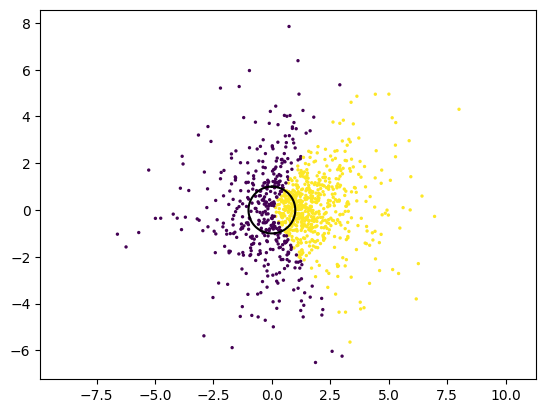

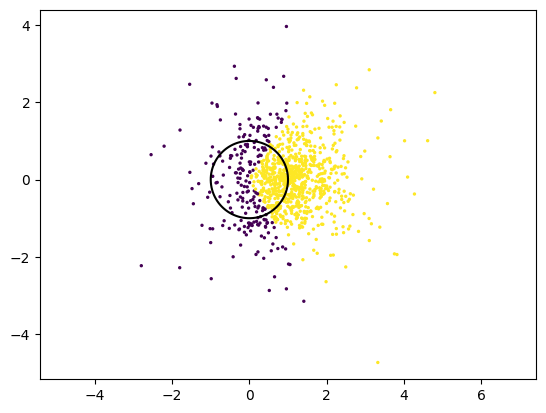

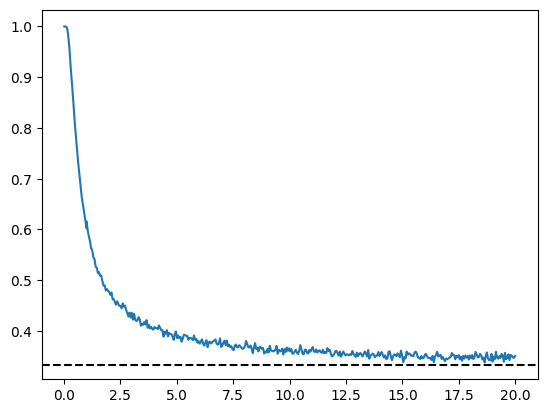

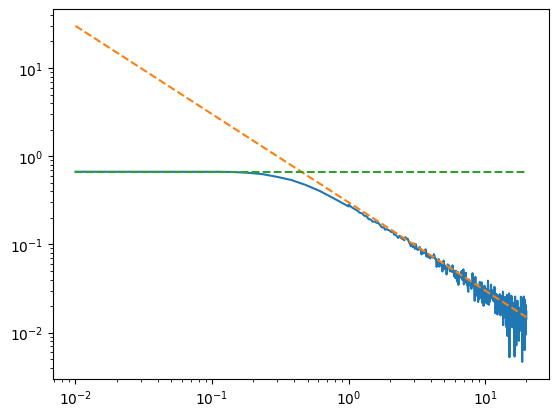

In [78]:

def p_d_r(d, r, n_samples=10000):
    X = np.eye(d)[0] + ExponentialIsotropicDistribution(d, r).random(n_samples)
    # return np.mean(X[:,0] / np.linalg.norm(X, axis=1) >= 1/d) # Equivalent
    X /= np.linalg.norm(X, axis=1, keepdims=True)
    return np.mean(X[:,0] >= 1/d)

d = 2
r = np.concatenate([np.geomspace(1e-2, 1, 20), np.linspace(1, 20, 380)])
y = np.array([p_d_r(2, r) for r in r])


X = np.eye(d)[0] + 1*ExponentialIsotropicDistribution(d).random(1000)
plt.scatter(*X.T, c=X[:,0] / np.linalg.norm(X, axis=1) >= 1/d, vmax=1, vmin=0, s=2)
plt.plot(np.sin(2*np.pi*np.linspace(0,1,100)), np.cos(2*np.pi*np.linspace(0,1,100)), color="black")
plt.axis("equal")
plt.show()
X = np.eye(d)[0] + 0.5*ExponentialIsotropicDistribution(d).random(1000)
plt.scatter(*X.T, c=X[:,0] / np.linalg.norm(X, axis=1) >= 1/d, vmax=1, vmin=0, s=2)
plt.plot(np.sin(2*np.pi*np.linspace(0,1,100)), np.cos(2*np.pi*np.linspace(0,1,100)), color="black")
plt.axis("equal")
plt.show()

plt.plot(r, y, label="d=2")
plt.axhline(1/(d+1), color="black", linestyle="--", label="1/(d+1)")
plt.show()


plt.plot(r, y-1/(d+1), label="d=2")
plt.plot(r, 0.3*r**-1, label="d=2", ls='--')
plt.plot(r, (d/(d+1))*np.ones_like(r), label="d=2", ls='--')
plt.xscale("log")
plt.yscale("log")
plt.show()




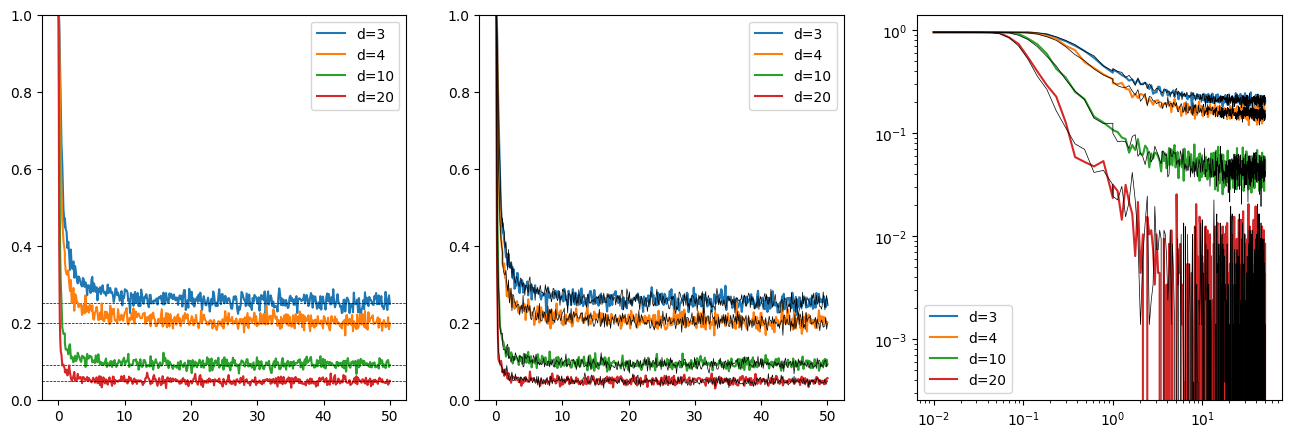

In [363]:

class CategoricalSimplex:
    """
    Embedding for a categorical variable with d categories. There are three types of embeddings:
    - The "categorical space" (cat), where each category is an integer from 0 to d-1
    - The "one-hot space" (oh) or "affine space", where each category is a one-hot vector (in d-dimensions)
    - The "linear space" (lin), where each category is a point in (d-1)-dimensions
    """

    def __init__(
        self,
        n_cat: int,
        lin_scale: Union[float, Literal["unit_side", "match_oh"]] = "match_oh",
        oh_scale: Union[float, Literal["unit_side", "match_lin"]] = 1,
    ):
        """
        lin_scale: float or 'unit_side' or 'match_oh'
            Radius of the simplex in the linear space.
        oh_scale: float or 'unit_side' or 'match_lin'
            Norm of the one-hot-encoded vectors in the one-hot space.
        """
        self.n_cat = n_cat
        self.d = d = n_cat - 1  # Dimensionality of the simplex

        # Default scales. Caution: side and radius scale simultaneously but not vertex_norm because of the affine map
        dt_scales = np.dtype(
            [
                ("vertex_norm", float),
                ("side", float),
                ("radius", float),
                ("factor", float),
            ]
        )
        Scale = lambda values, by: np.array(
            tuple(by * np.array(values.tolist())), dtype=dt_scales
        )
        s_oh = Scale(np.array([1, np.sqrt(2), np.sqrt(d / (d + 1)), 1]), 1.0)
        s_lin = Scale(np.array([1, s_oh["side"] / s_oh["radius"], 1, 1]), 1.0)
        s_lin["factor"] = 1

        # Parse the scale arguments
        f = lambda x, ref: cast(
            Union[float, None],
            1 / ref["side"] if x == "unit_side" else None if isinstance(x, str) else x,
        )
        _s_lin = f(lin_scale, s_lin)
        _s_oh = f(oh_scale, s_oh)
        if _s_lin is None or _s_oh is None:
            if _s_lin is not None:
                s_lin = Scale(s_lin, _s_lin)
                s_oh = Scale(s_oh, s_lin["radius"] / s_oh["radius"])
            elif _s_oh is not None:
                s_oh = Scale(s_oh, _s_oh)
                s_lin = Scale(s_lin, s_oh["radius"] / s_lin["radius"])
            else:
                raise Exception("Cannot have match_oh and match_lin simultaneously")
        else:
            s_lin = Scale(s_lin, _s_lin)
            s_oh = Scale(s_oh, _s_oh)
        self.lin_scale = s_lin
        self.oh_scale = s_oh

        V = self._simplex_vertices(d)  # of radius 1.
        self.isometry = np.sqrt(d / (d + 1)) * V

        self.lin_vertices = self.lin_scale["vertex_norm"] * V
        self.oh_vertices = self.oh_scale["vertex_norm"] * np.eye(d + 1)
        self.oh_centroid = np.mean(self.oh_vertices, axis=0)
        self.lin_volume = (
            np.sqrt((d + 1) / 2**d)
            / scipy.special.gamma(1 + d)
            * self.lin_scale["side"] ** d
        )
        self.oh_volume = (
            np.sqrt((d + 1) / 2**d)
            / scipy.special.gamma(1 + d)
            * self.oh_scale["side"] ** d
        )

    @staticmethod
    def _simplex_vertices(d: int):
        # The columns of V are the vertices of the d-dimensional simplex of radius 1
        assert d > 0
        V = np.array([[-1, 1]])
        k = 2
        while k <= d:
            V_i = [([-1 / k, *(np.sqrt(k**2 - 1) / k * u)]) for u in V.T]
            v_k = [1, *np.zeros(k - 1)]
            V = np.array([v_k, *V_i]).T
            k += 1
        return V

    def _clean_cat(self, X_cat: np.ndarray):
        assert np.all(np.isclose(X_cat, X_cat.astype(int))), X_cat
        X_cat = X_cat.astype(int)
        if len(X_cat.shape) == 2 and X_cat.shape[-1] == 1:
            X_cat = X_cat[:, 0]
        return X_cat

    def cat_to_oh(self, X_cat: np.ndarray):
        return self.oh_vertices.T[self._clean_cat(X_cat)]

    def cat_to_lin(self, X_cat: np.ndarray):
        return self.lin_vertices.T[self._clean_cat(X_cat)]

    def oh_to_cat(self, X: np.ndarray):
        return np.argmax(X, axis=-1)

    def lin_to_cat(self, X: np.ndarray):
        X_OH = self.lin_to_oh(X)
        return self.oh_to_cat(X_OH)

    def oh_to_lin(self, X_oh: np.ndarray):
        # X_oh has rows of one-hot vectors
        X_oh = X_oh / self.oh_scale["side"]
        X_lin = np.matmul(X_oh, self.isometry.T)
        return X_lin * self.lin_scale["side"]

    def lin_to_oh(self, X_lin: np.ndarray):
        X_lin = X_lin / self.lin_scale["side"]
        X_oh = np.matmul(X_lin[...,None,:], self.isometry)
        return X_oh * self.oh_scale["side"] + self.oh_centroid


def p_d_r(d, r, n_samples=1000):
    simp = CategoricalSimplex(n_cat=d+1, lin_scale=1)
    X = simp.lin_vertices[:,0] + ExponentialIsotropicDistribution(d, r).random(n_samples)
    y = simp.lin_to_cat(X)
    return np.mean(y == 0)

def p_d_r_2(d, r, n_samples=1000):
    X = ExponentialIsotropicDistribution(d, r).random(n_samples)
    X[:,0] += 1
    X /= np.linalg.norm(X, axis=-1, keepdims=True)
    thr = 0 if d==1 else scipy.stats.beta((d-1)/2, (d-1)/2).ppf(d/(d+1))*2 - 1
    return np.mean(X[:,0] >= thr)

r = np.concatenate([np.geomspace(1e-2, 1, 20), np.linspace(1, 50, 380)])
d_arr = [1, 2, 3, 4, 10, 20][-4:]
#Y1 = {d: np.array([p_d_r(d, ri) for ri in r]) for d in d_arr}
Y2 = {d: np.array([p_d_r_2(d, ri) for ri in r]) for d in d_arr}

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i_ax in range(3):
    plt.sca(axes[i_ax])
    shift = 1/(d+1) if i_ax==2 else 0
    if i_ax>=1:
        for (d,y) in Y2.items():
            plt.plot(r, y - shift, label=f"d={d}")
    for (d,y) in Y1.items():
        if i_ax==0:
            plt.plot(r, y - shift, label=f"d={d}")
            plt.axhline(1/(d+1), color="black", linestyle="--", lw=0.5)
        else:
            plt.plot(r, y - shift, color="black", lw=0.5)
    if i_ax==2:
        plt.xscale("log")
        plt.yscale("log")
    else:
        plt.ylim(0,1)
    plt.legend()
plt.show()

# for (d,y) in [*Y.items(), *Z.items()]:
#     plt.plot(r, y, label=f"d={d}")
#     plt.axhline(1/(d+1), color="black", linestyle="--", label="1/(d+1)")
# plt.legend()
# plt.show()
# plt.xscale("log")
# plt.yscale("log")


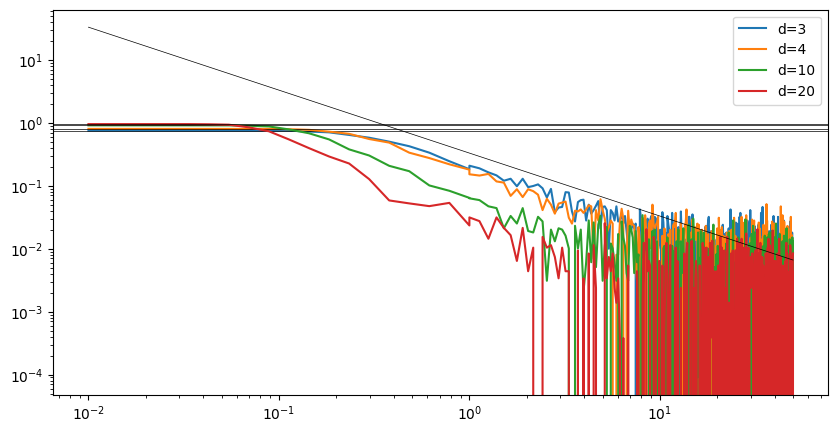

In [365]:

plt.subplots(1, 1, figsize=(10, 5))
for (d,y) in Y2.items():
    plt.plot(r, y-1/(d+1), label=f"d={d}")
    plt.axhline(1-1/(d+1), color="black", lw=0.5)

plt.plot(r, 0.33*r**-1, color='black', lw=0.5)
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()

/tmp/ipykernel_18700/1241742331.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(r), np.log(y-1/(d+1)), label=f"d={d}")
/tmp/ipykernel_18700/1241742331.py:3: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(r), np.log(y-1/(d+1)), label=f"d={d}")


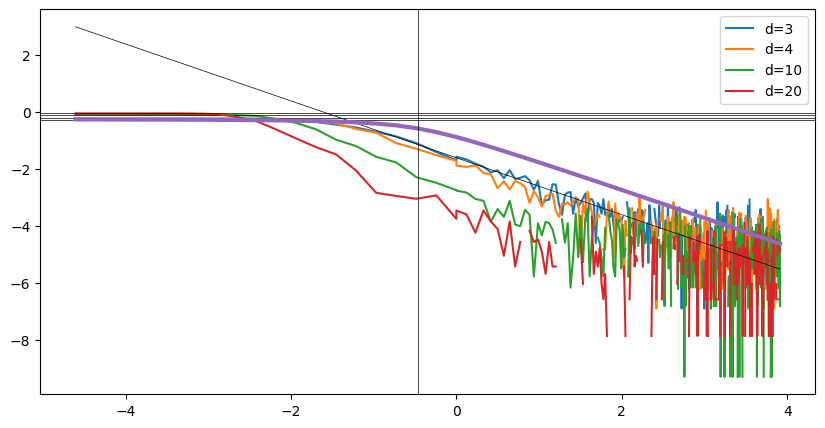

In [369]:

plt.subplots(1, 1, figsize=(10, 5))
for (d,y) in Y2.items():
    plt.plot(np.log(r), np.log(y-1/(d+1)), label=f"d={d}")
    plt.axhline(np.log(1-1/(d+1)), color="black", lw=0.5)

plt.plot(np.log(r), np.log(1/5*r**-1), color='black', lw=0.5)


square_plus = lambda b, x: (x+(x**2+b)**.5)/2

x = np.log(r)
d=4
x0 = (1/(d+1)-2/3)
plt.plot(x, np.log(1-1/(d+1))-square_plus(1/2, x-x0), lw=3)
plt.axvline(x0, color='black', lw=0.5)
plt.legend()
plt.show()

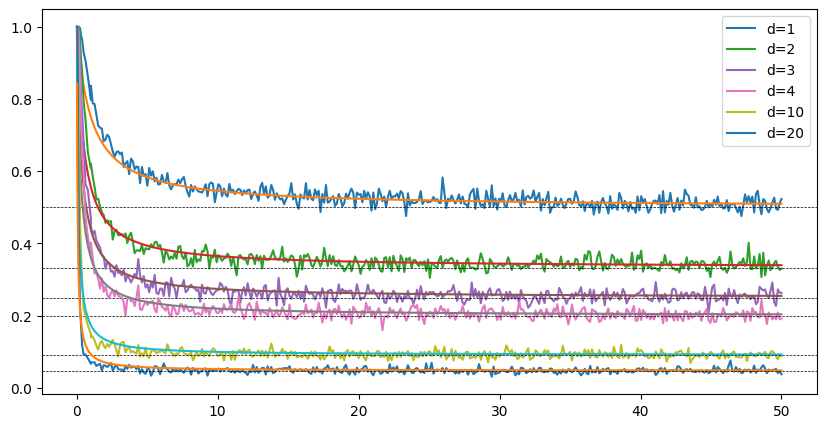

In [298]:

square_plus = lambda b, x: (x+(x**2+b)**.5)/2
plt.subplots(1, 1, figsize=(10, 5))
for (d,y) in Y.items():
    plt.plot(r, y, label=f"d={d}")
    plt.plot(r, 1/(d+1) + (d/(d+1)) / (1+d*r))
    plt.axhline(1/(d+1), color="black", linestyle="--", lw=0.5)


plt.legend()
plt.show()

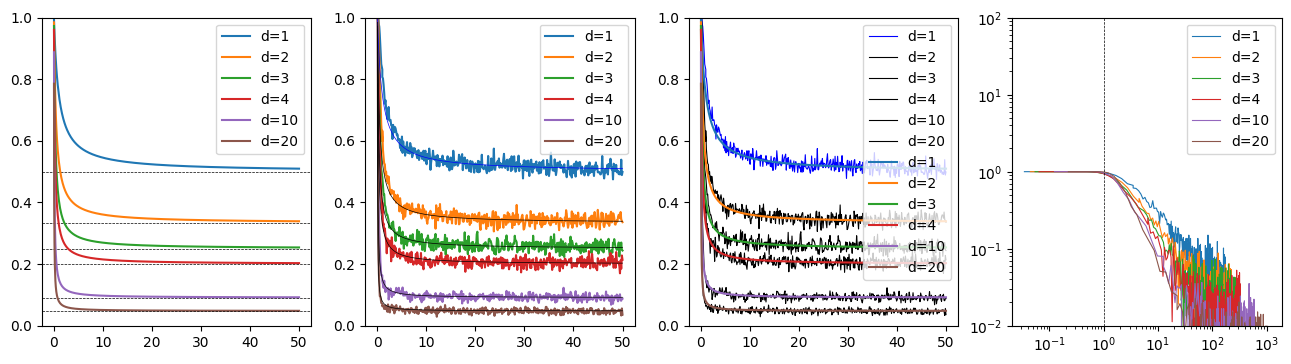

In [727]:

def p_d_r_3(d, r):
    square_plus = lambda b, x: (x+(x**2+b)**.5)/2
    softplus = lambda x: np.log(1+np.exp(x))
    return 1/(d+1) + (d/(d+1)) / (1+np.maximum(0, r * d*(1.5-1/(d+1))))
    return 1/(d+1) + (d/(d+1)) / (1+np.maximum(0, r * d - d/(d+2)))
    return 1/(d+1) + (d/(d+1)) * np.exp(np.minimum(-np.log(r) -np.log(np.log(d) + np.log(d) + d), softplus(np.log(r))))
    return 1/(d+1) + (d/(d+1)) * np.exp(-np.maximum(np.log(r)+ np.log(d), softplus(np.log(r))))
    return 1/(d+1) + (d/(d+1)) * np.exp(-np.maximum(0, np.log(r) + np.log(np.log(d)+d)))
    return 1/(d+1) + (d/(d+1)) * np.exp(np.minimum(-(np.log(d)+np.log(r)), np.maximum(0,np.log(r))))

    return 1/(d+1) + (d/(d+1)) * np.exp(-np.maximum(np.maximum(0,np.log(r)), np.minimum(np.log(r), d**3) + d**(3/8) ))
    return 1/(d+1) + (d/(d+1)) * np.exp(np.minimum(-((0.578+(np.log(r)+0.944))), np.maximum(0, np.log(r))))
    # return 1/(d+1) + (d/(d+1)) * 1/(np.maximum((d*r), np.sqrt(1/(d*r))))
    # return 1/(d+1) + (d/(d+1)) * np.maximum(0,1/(np.log(r))) /(np.log(np.maximum(0,1/(np.log(r)))/(-np.log(r) - d*np.log(r)- np.sqrt(d)*d/ np.log(r))) - np.log(r)*d - d/np.log(r)*np.sqrt(d))
    # return 1/(d+1) + (d/(d+1)) / (1+square_plus(1/5, r*d - d/(d+2)))
    # return 1/(d+1) + (d/(d+1)) / (1+soft_plus(r*d - d/(d+2)))
    # return 1/(d+1) + (d/(d+1)) / np.exp(r*d)

r = np.concatenate([np.geomspace(1e-2, 1, 20), np.linspace(1, 50, 380)])
d_arr = [1, 2, 3, 4, 10, 20]
# Y1 = {d: np.array([p_d_r(d, ri) for ri in r]) for d in d_arr}
# Y2 = {d: np.array([p_d_r_2(d, ri) for ri in r]) for d in d_arr}
Y3 = {d: np.array([p_d_r_3(d, ri) for ri in r]) for d in d_arr}

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i_ax in range(4):
    plt.sca(axes[i_ax])
    if i_ax==1:
        for (d,y) in Y1.items():
            plt.plot(r, y, label=f"d={d}")
    if i_ax<=1:
        for (d,y) in Y3.items():
            if i_ax==0:
                plt.plot(r, y, label=f"d={d}")
                plt.axhline(1/(d+1), color="black", linestyle="--", lw=0.5)
            else:
                plt.plot(r, y, color="blue" if d==1 else "black", lw=0.5)
    if i_ax==2:
        for (d,y) in Y1.items():
            plt.plot(r, y, label=f"d={d}", lw=0.8, color="blue" if d==1 else "black")
        for (d,y) in Y3.items():
            plt.plot(r, y, label=f"d={d}")
        # plt.ylim(1e-2, 1e2)
    if i_ax==3:
        for (d,y) in Y1.items():
            shift = 1/(d+1)
            downscale = d/(d+1)
            yy = ((y - shift)/downscale)
            # yy = pd.Series(yy).rolling(10, center=True).median().values
            plt.plot((d+2.5)*r, yy, label=f"d={d}", lw=0.8)
        plt.axvline(1, color="black", linestyle="--", lw=0.5)
        # if i_ax==0:
        #     plt.plot(r, (y - shift)/downscale, label=f"d={d}")
        #     plt.axhline(1/(d+1), color="black", linestyle="--", lw=0.5)
        # else:
    #     plt.plot(r, (y - shift)/downscale, color="blue" if d==1 else "black", lw=0.5)
        plt.xscale("log")
        plt.yscale("log")
        plt.ylim(1e-2, 1e2)
    else:
        plt.ylim(0,1)
    plt.legend()
plt.show()


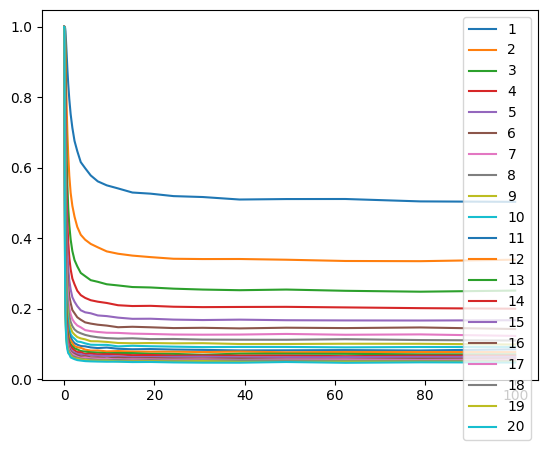

,r,d,p
0,0.01,1,1.00000
1,0.01,2,1.00000
2,0.01,3,1.00000
3,0.01,4,1.00000
4,0.01,5,1.00000
...,...,...,...
795,100.00,16,0.05885
796,100.00,17,0.05622
797,100.00,18,0.05273
798,100.00,19,0.05009


In [602]:


r = np.concatenate([np.geomspace(1e-2, 1e2, 40)])
d_arr = np.arange(1, 21)
Y = {d: np.array([p_d_r(d, ri, n_samples=100000) for ri in r]) for d in d_arr}
df = pd.DataFrame(Y)#.unstack().reset_index()

# Rolling mean
df.index = r

df.plot()
plt.show()
df = df.stack().reset_index().rename(columns={'level_0':'r', 'level_1':'d', 0:'p'})
backup = df.copy()
df


/home/carlos/applications/python311-env/lib64/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/carlos/applications/python311-env/lib64/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/carlos/applications/python311-env/lib64/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_gro

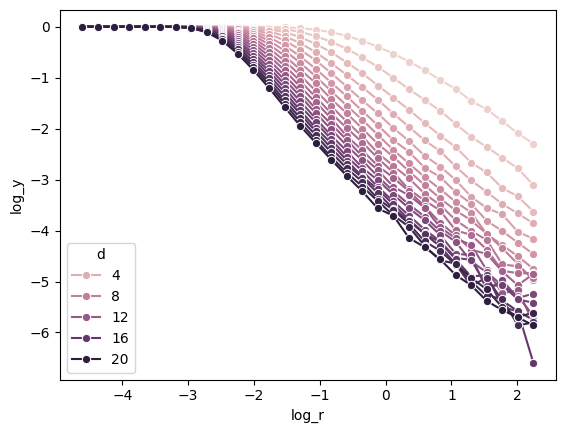

In [617]:
df = backup.copy()

df['log_r'] = np.log(df['r'])
df = df[df['log_r'] < 2.3]
df['y'] = (df['p']-1/(df['d']+1)) / (df['d']/(df['d']+1))
df['log_y'] = np.log(df['y'])
sns.lineplot(df, x='log_r', y='log_y', hue='d', marker='o')
plt.show()


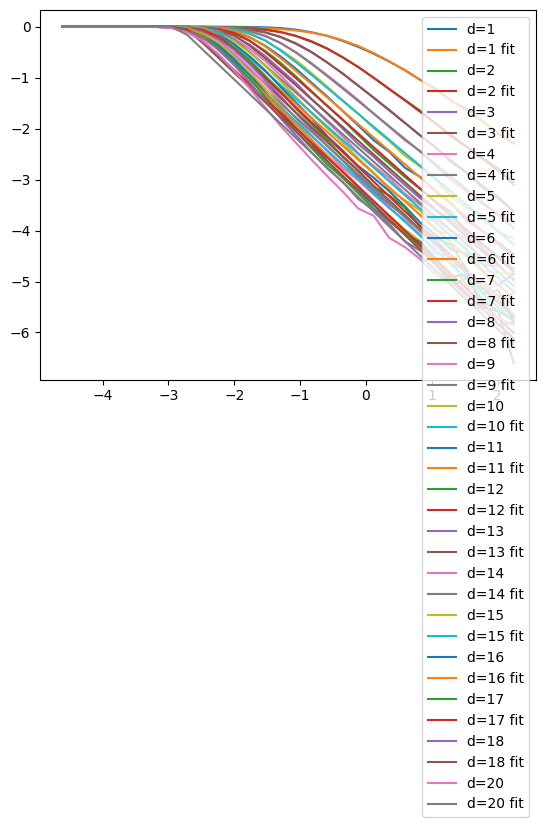

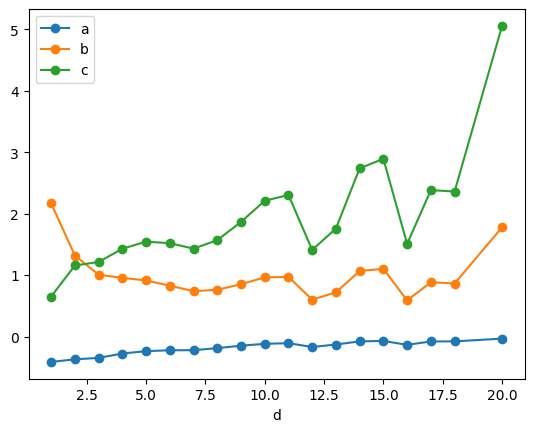

In [643]:

def f(r, a, b, c):
    return a*np.log1p(np.exp(b*d*r + d*c))

# Use scipy.optimize.curve_fit to find the best parameters

from scipy.optimize import curve_fit

Xy = df[['log_r', 'd', 'log_y']].dropna().values
assert np.all(np.isfinite(Xy))
X = Xy[:,:2]
y = Xy[:,2]

opt = []
# Optimize conditioning on d
for d in df['d'].unique():
    Xd = X[X[:,1]==d]
    yd = y[X[:,1]==d]
    try:
        popt, pcov = curve_fit(f, Xd[:,0], yd, p0=[1, 1, 1])
    except RuntimeError:
        continue
    opt.append([d, *popt])
    plt.plot(Xd[:,0], yd, label=f"d={d}")
    plt.plot(Xd[:,0], f(Xd[:,0], *popt), label=f"d={d} fit")
plt.legend()
plt.show()
pd.DataFrame(opt, columns=["d", "a", "b", "c"]).set_index("d").plot(marker='o')
plt.show()

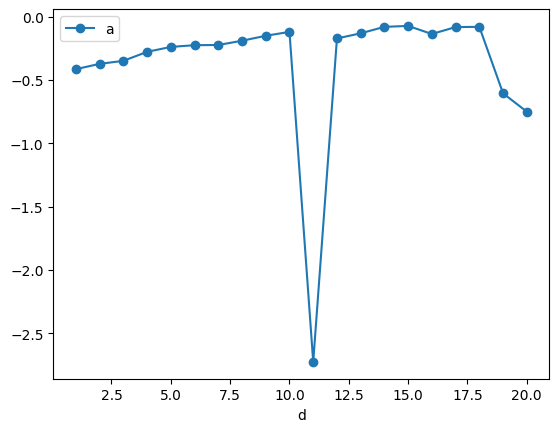

In [622]:
pd.DataFrame(opt, columns=["d", "a", "b", "c"]).set_index("d")[["a"]].plot(marker='o')
plt.show()

In [614]:

# Use gplearn (it did not work. I'm a bit disapointed)

from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from sklearn.model_selection import train_test_split
import numpy as np

# Define your data
# X = df[['r', 'd']].values
# y = df['p'].values

Xy = df[['log_r', 'd', 'log_y']].dropna().values
Xy = Xy[np.isfinite(Xy).all(axis=1)]  # Remove rows with NaNs
assert np.all(np.isfinite(Xy))
X = Xy[:,:2]
y = Xy[:,2]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the function set
function_set = []
function_set.extend(['add', 'mul', 'sqrt', 'log', 'abs', 'neg', 'inv', 'max', 'min'])
function_set.append(make_function(function=lambda x:np.exp(np.minimum(x, 100)), name='exp',arity=1))
# function_set.append(make_function(function=lambda x:np.maximum(x, 0), name='relu',arity=1))
function_set.append(make_function(function=lambda x: np.log1p(np.exp(x)), name='softplus',arity=1))
# function_set.append(make_function(function=lambda x,y:np.maximum(0,x)**np.minimum(np.abs(y), 20), name='pow', arity=2))

# Create and fit the symbolic regressor with custom parameters
est_gp = SymbolicRegressor(generations=50, population_size=1500, parsimony_coefficient=0.008, function_set=function_set, random_state=42, verbose=1)
est_gp.fit(X_train, y_train)

# Print the evolved formula
print("Evolved Formula:", est_gp._program)

# Evaluate the performance on the test set
score = est_gp.score(X_test, y_test)
print("R-squared Score on Test Set:", score)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/tmp/ipykernel_18700/2206583899.py:26: RuntimeWarning: overflow encountered in exp
  function_set.append(make_function(function=lambda x: np.log1p(np.exp(x)), name='softplus',arity=1))


   0    10.63              inf        4          1.15126              N/A     38.46s
   1     8.45              inf       11         0.854311              N/A     44.68s
   2     8.33      8.61576e+37        9         0.643309              N/A     42.57s


/home/carlos/applications/python311-env/lib64/python3.11/site-packages/gplearn/functions.py:144: RuntimeWarning: overflow encountered in divide
  return np.where(np.abs(x1) > 0.001, 1. / x1, 0.)


   3     8.67              inf        8         0.524972              N/A     37.92s
   4    10.96          34453.9       21         0.515266              N/A     43.84s
   5    10.51          2.50723       17         0.350252              N/A     36.75s
   6    11.21          2.29374       24         0.340421              N/A      1.49m
   7    10.90          2.07439       29         0.340421              N/A     37.89s
   8    10.38          50770.3       29         0.316152              N/A     32.12s
   9     8.45          1.81093       10         0.350013              N/A     30.65s
  10     8.99       3.7335e+38       10         0.324596              N/A     30.65s
  11     9.03      3.43398e+21       13         0.299425              N/A     29.59s
  12     9.29          25385.5       12         0.277425              N/A     28.74s
  13     9.43          1.78756       12         0.277425              N/A     28.57s
  14    10.85            25386       12         0.277425         

In [570]:
np.exp(np.minimum(-(np.log(d)+np.log(r)), np.maximum(0,np.log(r))))


np.exp(np.minimum(-(np.log(d)+np.log(r)), np.maximum(0,np.log(r))))

np.exp(-np.maximum(0, np.log(r) + np.log(np.log(d)+d)))
# -np.maximum(np.log(r)+ np.log(d), softplus(np.log(r)))

# np.minimum(-np.log(r) -np.log(np.log(d) + np.log(d) + d), softplus(np.log(r)))

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.22310584,
       -0.45926842, -0.69543099, -0.93159357, -1.16775614, -1.40391871,
       -1.64008129, -1.87624386, -2.11240643, -2.34856901, -2.58473158,
       -2.82089416, -3.05705673, -3.2932193 , -3.52938188, -3.76554445,
       -4.00170702, -4.2378696 , -4.47403217, -4.71019474, -4.94635732,
       -5.18251989, -5.41868247, -5.65484504, -5.89100761, -6.12717019])